In [1]:
import sys
import torch


seed = 42
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree
import fiora.visualization.spectrum_visualizer as sv

from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print(f'Working with Python {sys.version}')


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


## Data

In [2]:
# key map to read metadata from pandas DataFrame
metadata_key_map = {
                "name": "Name",
                "collision_energy":  "CE", 
                "instrument": "Instrument_type",
                "ionization": "Ionization",
                "precursor_mz": "PrecursorMZ",
                "precursor_mode": "Precursor_type",
                "retention_time": "RETENTIONTIME",
                "ccs": "CCS"
                }


#
# Load specified libraries and align metadata
#

def load_training_data():
    L = LibraryLoader()
    df = L.load_from_csv(f"{home}/data/metabolites/preprocessed/training_min2.csv")
    return df

df = load_training_data()

# Restore dictionary values
dict_columns = ["peaks", "summary"]
for col in dict_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    #df[col] = df[col].apply(ast.literal_eval)
    
df['group_id'] = df['group_id'].astype(int)


In [3]:
print(df.groupby("dataset")["group_id"].unique().apply(len))

print("Reducing data to test set.")
df_train = df[df["dataset"] != "test"]
df_test = df[df["dataset"] == "test"]

dataset
test           1296
train         10366
validation     1296
Name: group_id, dtype: int64
Reducing data to test set.


In [4]:
%%capture
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder


CE_upper_limit = 80.0
weight_upper_limit = 800.0


df_test["Metabolite"] = df_test["SMILES"].apply(Metabolite)
df_train["Metabolite"] = df_train["SMILES"].apply(Metabolite) # TRAIN Metabolites are only tracked for tanimoto distance
df_test["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

df_test["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_test.apply(lambda x: x["Metabolite"].set_id(x["group_id"]) , axis=1)

#df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df_test.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)


In [5]:
%%capture
df_test["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_test.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=x["ppm_peak_tolerance"]), axis=1)

##### Load Casmi data

In [6]:
casmi16_path = f"{home}/data/metabolites/CASMI_2016/casmi16_withCSS.csv"
casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_withCSS.csv"

df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)

# Restore dictionary values
dict_columns = ["peaks", "Candidates"]
for col in dict_columns:
    df_cas[col] = df_cas[col].apply(ast.literal_eval)

df_cas22["peaks"] = df_cas22["peaks"].apply(ast.literal_eval)
df_cas22["ChallengeNum"] = df_cas22["ChallengeName"].apply(lambda x: int(x.split("-")[-1]))
df_cas22["is_priority"] = df_cas22["ChallengeNum"] < 250





def closest_cfm_ce(CE):
    ref = np.array([10, 20, 40])
    abs_error = abs(ref - CE)
    i = np.argmin(abs_error)
    return str(ref[i])

In [7]:
%%capture
from fiora.MOL.collision_energy import NCE_to_eV

df_cas["dataset"] = "CASMI 16"
df_cas["RETENTIONTIME"] = df_cas["RTINSECONDS"] / 60.0
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df_cas["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas["CE"] = 20.0 # actually stepped 20/35/50
df_cas["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cas["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1) # Optional: use mz_cut instead

#
# CASMI 22
#

df_cas22["dataset"] = "CASMI 22"
df_cas22["Metabolite"] = df_cas22["SMILES"].apply(Metabolite)
df_cas22["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas22["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas22["CE"] = df_cas22.apply(lambda x: NCE_to_eV(x["NCE"], x["precursor_mz"]), axis=1)
df_cas22 = df_cas22[df_cas22["CE"] < CE_upper_limit] 
df_cas22 = df_cas22[df_cas22["CE"] > 0] 
df_cas22 = df_cas22[df_cas22.is_priority]

metadata_key_map22 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "precursor_mz",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "ChallengeRT"
                 }

df_cas22["summary"] = df_cas22.apply(lambda x: {key: x[name] for key, name in metadata_key_map22.items()}, axis=1)
df_cas22.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

# Fragmentation
df_cas22["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas22.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1) # Optional: use mz_cut instead

df_cas22 = df_cas22.reset_index()

df_cas22["library"] = "CASMI-22"
df_cas22["RETENTIONTIME"] = df_cas22["ChallengeRT"] # "RT_min"
df_cas22["cfm_CE"] = df_cas22["CE"].apply(closest_cfm_ce)
df_cas22[["NCE", "CE", "cfm_CE"]]

In [8]:
df_cas22[~df_cas22.CCS.isna()]

,level_0,index,RT,RT_min,precursor_mz,Instrument_type,NCE,peaks,Precursor_type,ChallengeName,...,CCS_std,ChallengeNum,is_priority,dataset,Metabolite,CE,summary,library,RETENTIONTIME,cfm_CE


## Model Training and Testing

In [9]:
from fiora.GNN.Trainer import Trainer
import torch_geometric as geom

if torch.cuda.is_available(): 
 dev = "cuda:3"
else: 
 dev = "cpu" 
 
print(f"Running on device: {dev}")




Running on device: cuda:3


##### Prepare Model

In [10]:
MODEL_PATH = f"{home}/data/metabolites/pretrained_models/pre_package/v0.0.1_merged_depth2.pt"

In [11]:
import json
from fiora.GNN.GNNModules import GNNCompiler
from fiora.MS.SimulationFramework import SimulationFramework

try: 
    model = GNNCompiler.load(MODEL_PATH)
except:
    try:
        print(f"Warning: Failed loading the model {MODEL_PATH}. Fall back: Loading the model from state dictionary.")
        model = GNNCompiler.load_from_state_dict(MODEL_PATH)
        print("Model loaded from state dict without further errors.")
    except:
        raise NameError("Error: Failed loading from state dict.")
        

model.eval()
model = model.to(dev)

fiora = SimulationFramework(None, dev=dev, with_RT=True, with_CCS=True)


model.model_params

Model loaded from state dict without further errors.


{'param_tag': 'default',
 'gnn_type': 'RGCNConv',
 'depth': 2,
 'hidden_dimension': 300,
 'dense_layers': 2,
 'embedding_aggregation': 'concat',
 'embedding_dimension': 300,
 'input_dropout': 0.2,
 'latent_dropout': 0.1,
 'node_feature_layout': {'symbol': 10, 'num_hydrogen': 5, 'ring_type': 5},
 'edge_feature_layout': {'bond_type': 4, 'ring_type': 5},
 'static_feature_dimension': 9,
 'static_rt_feature_dimension': 8,
 'output_dimension': 10,
 'atom_features': ['bond_type', 'ring_type'],
 'setup_features': ['collision_energy',
  'molecular_weight',
  'precursor_mode',
  'instrument'],
 'rt_features': ['molecular_weight', 'precursor_mode', 'instrument']}

##### Begin Training

In [12]:
np.seterr(invalid='ignore')
def simulate_all(model, DF):
    return fiora.simulate_all(DF, model)

    
def test_model(model, DF):
    dft = simulate_all(model, DF)
    return dft

##### Test CASMI 16 and 22

In [13]:
from fiora.MOL.collision_energy import NCE_to_eV
from fiora.MS.spectral_scores import spectral_cosine, spectral_reflection_cosine, reweighted_dot
from fiora.MS.ms_utility import merge_annotated_spectrum


def test_cas16(model, df_cas=df_cas):
    
    df_cas["NCE"] = 20.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step1_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_20")

    df_cas["NCE"] = 35.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step2_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_35")


    df_cas["NCE"] = 50.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step3_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_50")

    df_cas["avg_CE"] = (df_cas["step1_CE"] + df_cas["step2_CE"] + df_cas["step3_CE"]) / 3
    df_cas["CE"] = df_cas["avg_CE"]
    
    df_cas["merged_peaks"] = df_cas.apply(lambda x: merge_annotated_spectrum(merge_annotated_spectrum(x["sim_peaks_20"], x["sim_peaks_35"]), x["sim_peaks_50"]) , axis=1)
    df_cas["sim_peaks"] = df_cas["merged_peaks"] 
    df_cas["merged_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["merged_sqrt_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_sqrt_bias"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt, with_bias=True)[1], axis=1)
    df_cas["merged_sqrt_cosine_wo_precursor"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt, remove_mz=x["Metabolite"].get_theoretical_precursor_mz(x["Metabolite"].metadata["precursor_mode"])), axis=1)
    df_cas["merged_refl_cosine"] = df_cas.apply(lambda x: spectral_reflection_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_steins"] = df_cas.apply(lambda x: reweighted_dot(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["spectral_sqrt_cosine"] = df_cas["merged_sqrt_cosine"] # just remember it is merged
    df_cas["spectral_sqrt_bias"] = df_cas["merged_sqrt_bias"] # just remember it is merged

    df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"])
    df_cas["RT_pred"] = df_cas["RT_pred_35"]
    df_cas["RT_dif"] = df_cas["RT_dif_35"]
    df_cas["CCS_pred"] = df_cas["CCS_pred_35"]
    df_cas["library"] = "CASMI-16"

    
    df_cas["cfm_CE"] = df_cas["avg_CE"].apply(closest_cfm_ce)
    
    return df_cas

In [14]:
print(f"Testing the model")
np.seterr(invalid='ignore')
df_test = test_model(model, df_test)
df_cas = test_cas16(model)
df_cas22 = test_model(model, df_cas22)
print("Done")

Testing the model


/home/ynowatzk/repos/fiora/fiora/MS/SimulationFramework.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(columns=[x + suffix for x in ["cosine_similarity", "kl_div", "sim_peaks", "spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_sqrt_bias_wo_prec", "spectral_refl_bias", "steins_cosine", "steins_bias", "RT_pred", "RT_dif", "CCS_pred"]])])
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divid

Done


#### READ CFM-ID Results

In [15]:
import fiora.IO.cfmReader as cfmReader
# time CFM-ID 4: -> 12m16,571s

cf = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi16_negative_predictions.txt", as_df=True)
cf_p = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi16_positive_predictions.txt", as_df=True)
cf = pd.concat([cf, cf_p])
len(cf[cf["#ID"] == "Challenge-009"]) ## missing chalenges
df_cas["cfm_peaks"] = None
df_cas[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, cas in df_cas.iterrows():
    challenge = cas["ChallengeName"]

    if len(cf[cf["#ID"] == challenge]) != 1:
        print(f"{challenge} not found in CFM-ID results. Skipping.")
        continue
    cfm_data = cf[cf["#ID"] == challenge].iloc[0]
    
    
    if cas["ChallengeName"] != cfm_data["#ID"]:
        raise ValueError("Wrong challenge matched")
    cfm_peaks = cfm_data["peaks" + cas["cfm_CE"]] # find best reference CE
    df_cas.at[i, "cfm_peaks"] = cfm_peaks
    df_cas.at[i, "cfm_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks)
    df_cas.at[i, "cfm_sqrt_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas.at[i, "cfm_steins"] = reweighted_dot(cas["peaks"], cfm_peaks)

Challenge-009 not found in CFM-ID results. Skipping.
Challenge-051 not found in CFM-ID results. Skipping.
Challenge-053 not found in CFM-ID results. Skipping.
Challenge-066 not found in CFM-ID results. Skipping.


In [16]:
import fiora.IO.cfmReader as cfmReader
# time CFM-ID 4: -> 12m16,571s



cf22 = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi22_negative_predictions.txt", as_df=True)
cf22_p = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi22_positive_predictions.txt", as_df=True)
cf22 = pd.concat([cf22, cf22_p])
df_cas22["cfm_peaks"] = None
df_cas22[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, cas in df_cas22.iterrows():
    challenge = cas["ChallengeName"]

    if len(cf22[cf22["#ID"] == challenge]) != 1:
        print(f"{challenge} not found in CFM-ID results. Skipping.")
        continue
    cfm_data = cf22[cf22["#ID"] == challenge].iloc[0]
    
    
    if cas["ChallengeName"] != cfm_data["#ID"]:
        raise ValueError("Wrong challenge matched")
    cfm_peaks = cfm_data["peaks" + cas["cfm_CE"]] # find best reference CE
    df_cas22.at[i, "cfm_peaks"] = cfm_peaks
    df_cas22.at[i, "cfm_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks)
    df_cas22.at[i, "cfm_sqrt_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas22.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas22.at[i, "cfm_steins"] = reweighted_dot(cas["peaks"], cfm_peaks)

In [17]:

paths = {"[M-H]-": f"{home}/data/metabolites/cfm-id/test_pred_neg/", "[M+H]+": f"{home}/data/metabolites/cfm-id/test_pred_pos/"}
df_test["cfm_CE"] = df_test["CE"].apply(closest_cfm_ce)
df_test["cfm_peaks"] = None
df_test[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, data in df_test.iterrows():
    group_id = data["group_id"]
    p = paths[data["Precursor_type"]] + str(int(group_id)) + ".txt"
    cfm_data = cfmReader.read(p, as_df=True)
    
    # TODO Check smiles / MOL
    if cfm_data.shape == (0, 0): # Not predicted by CFM-ID
        continue
        
    cfm_peaks = cfm_data["peaks" + data["cfm_CE"]].iloc[0]

    df_test.at[i, "cfm_peaks"] = cfm_peaks
    df_test.at[i, "cfm_cosine"] = spectral_cosine(data["peaks"], cfm_peaks)
    df_test.at[i, "cfm_sqrt_cosine"] = spectral_cosine(data["peaks"], cfm_peaks, transform=np.sqrt)
    df_test.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(data["peaks"], cfm_peaks, transform=np.sqrt)
    df_test.at[i, "cfm_steins"] = reweighted_dot(data["peaks"], cfm_peaks)


#### ICEBERG / SCARF
Load spectra predicted by ICEBERG and SCARF by Goldman et. al (2023). Prediction via: https://github.com/samgoldman97/ms-pred 

In [18]:
# # Write training set to specific ICEBERG format
# import fiora.IO.mspredWriter as mspredWriter
# # calls rename(columns=header_map)
# header_map = {"dataset_label": "dataset", "idx": "spec", "Name": "name",  "Precursor_type": "ionization"}
# df_train["dataset_label"] = "df_train"
# df_train["idx"] = [f"spec{i}" for i in range(0, len(df_train))]

# # Note: [M-H]- precursors lead to errors with ICEBERG/magma. Also: Sn (tin) element and Au (gold) causes error. Needs manual removal.
# # mspredWriter.write_dataset(df_train[df_train["Precursor_type"] == "[M+H]+"], f"{home}/repos/ms-pred/data/spec_datasets/df_train/", label_map=header_map)


# d = f"{home}/repos/ms-pred/data/spec_datasets/df_train_wErrors/magma_outputs/magma_tsv"
# import os

# # In order to rerun without errors, select only spec that doesn't cause an error. (requires running magma with the whole dataset first)
# working = set([s.split(".")[0] for s in os.listdir(d)])
# #mspredWriter.write_dataset(df_train[df_train["idx"].apply(lambda x: x in working)], f"{home}/repos/ms-pred/data/spec_datasets/df_train/", label_map=header_map)

# # # Create split.tsv
# # df_split = df_train[df_train["idx"].apply(lambda x: x in working)][["idx", "dataset"]].copy()
# # df_split = df_split.rename(columns={"idx": "spec", "dataset": "Fold_0"})
# # df_split["Fold_0"] = df_split["Fold_0"].str.replace("validation", "val")
# # df_split.to_csv(f"{home}/repos/ms-pred/data/spec_datasets/df_train/splits/split1.tsv", index=False, sep="\t")

In [19]:



#
# Rerunning EVERYTHING AGAIN (avoiding crashes this time, fingers crossed)
# 
# time . data_scripts/y_all_assign_subform.sh: 2471m28,695s
# time . data_scripts/dag/y_run_magma.sh: 1810m9,266s 
# 64222 spec
#
# time bash run_scripts/dag_model/01_run_dag_gen_train.sh: 1151m8,021s
# time python run_scripts/dag_model/02_sweep_gen_thresh.py: 0s
# time bash run_scripts/dag_model/03_run_dag_gen_predict.sh: 585m29,891s
# time bash run_scripts/dag_model/04_train_dag_inten.sh: 
#



# raise KeyboardInterrupt("HALT")
#
# Retraining on my dataset
# run_magma: 1853m13,787s -> has ~1000 missing but 64222/65285 calculated (>98%).
# assign_all_subformulae: 2487m16,694s 65285 specs calculated
# 01 dag train: 66117.73s
# 02 sweep: 0
# 03 dag_gen_predict: 405m21,170s (with crash)
# 04 


# v1.0.0 doesn't allow proper retraining, many scripts missing. 
# -> Running on commit: update scarf figs to \pm SEM, instead of confidence -> fa502056d601e843351e4bdfe0e173d65e8105a1
# run magma took: 347m20,902s
# run subformula: 620m54,021s
# run 01dag train: 37967.52s -> 10,5h
# run 03_run_dag_gen_predict 6692.45s 112m9,625s # Note: the right version must be explicitly named in the config file.
# run 04_inten train 786m57,268s


# Just positives CASMI16. ICEBERG took 98.5s (--gpu threw error though)
#raise KeyboardInterrupt()
import fiora.IO.mspredReader as mspredReader

iceberg_dir = f"{home}/repos/ms-pred/results/test_out/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)

In [20]:
# # Training set used for ICEBERG/SCARF public model
# ice_train_path = f"{home}/repos/ms-pred/data/spec_datasets/canopus_train_public/labels.tsv"

# icy = pd.read_csv(ice_train_path, sep="\t")
# icy["Metabolite"] = icy["smiles"].apply(Metabolite)

In [21]:
# ## Available open-source ICEBERG/SCARF models unfortunately violate with our test/train separation
# iii = []
# xxx = []
# for i,d in df_cas.iterrows():
#     m = d["Metabolite"]
    
#     for x,D in icy.iterrows():
#         M = D["Metabolite"]
#         if (m == M):
#             iii += [i]
#             xxx += [x]       
# iii = np.unique(iii)  
# print(f"Found {len(iii)} instances violating test/train split. Metabolite found in train/val set.") # out of 123
# print(f"Dropping {len(xxx)} spectra from training DataFrame.")

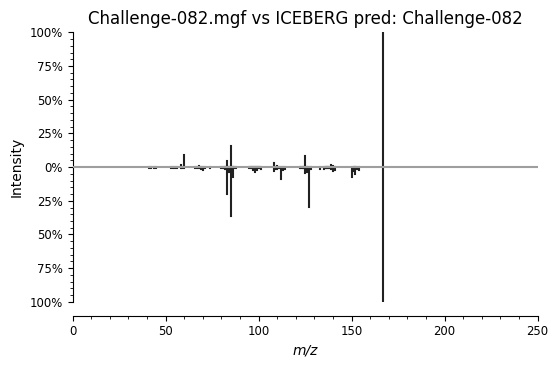

In [22]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(6,3.5))
i = 0
ax = sv.plot_spectrum(df_cas.iloc[81 + i], df_ice.iloc[i], title=df_cas.iloc[81 + i]["FILE"] + " vs ICEBERG pred: " + df_ice.iloc[i]["name"], highlight_matches=False, with_grid=False, ax=ax)
ax.spines['bottom'].set_position(('outward', 10))
plt.show()

In [23]:
df_train.columns

Index(['Name', 'Synon', 'Notes', 'Precursor_type', 'Spectrum_type',
       'PrecursorMZ', 'Instrument_type', 'Instrument', 'Sample_inlet',
       'Ionization', 'Collision_energy', 'Ion_mode', 'Special_fragmentation',
       'InChIKey', 'Formula', 'MW', 'ExactMass', 'CASNO', 'NISTNO', 'ID',
       'Comment', 'Num peaks', 'peaks', 'Link', 'Related_CAS#',
       'Collision_gas', 'Pressure', 'In-source_voltage', 'msN_pathway', 'MOL',
       'SMILES', 'InChI', 'K', 'ExactMolWeight', 'matching_key',
       'theoretical_precursor_mz', 'precursor_offset', 'CE', 'CE_type',
       'peak_matches', 'num_peaks_matched', 'match_stats',
       'num_unique_peaks_matched', 'num_conflicts_in_peak_matching',
       'match_mode_counts', 'RETENTIONTIME', 'CCS', 'PPM_num',
       'ppm_peak_tolerance', 'lib', 'origin', 'level_0', 'index', 'NAME',
       'PRECURSORMZ', 'PRECURSORTYPE', 'IONMODE', 'FORMULA', 'ONTOLOGY',
       'INCHIKEY', 'INSTRUMENTTYPE', 'COLLISIONENERGY', 'COMMENT', 'Num Peaks',
       'Met

In [24]:
# df_train["formula"] = df_train.apply(lambda x: x["FORMULA"] if not np.isnan(x["FORMULA"]) else x["Formula"], axis=1)  


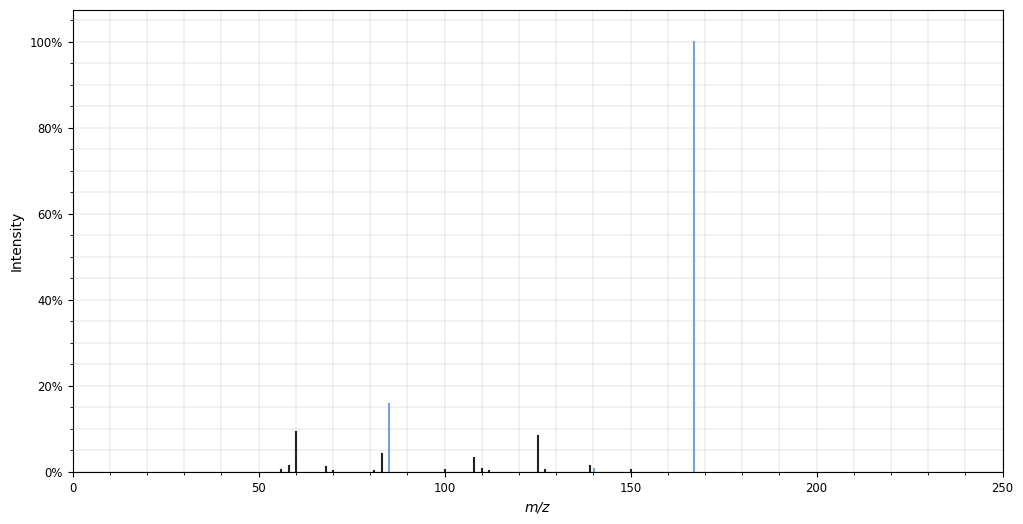

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sv.annotate_and_plot(df_cas.iloc[81 + i], [140.093, 167.10, 85.05], with_grid=True, ax=ax)
plt.show()

In [26]:
## TODO Retrain & (re) test iceberg model
score = "spectral_sqrt_cosine"
avg_func = np.median
fiora_res = {"model": "Fiora", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score]), "Test-": avg_func(df_test[df_test["Precursor_type"] == "[M-H]-"][score]), "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score]), "CASMI16-":avg_func(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score]), "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score]), "CASMI22-": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score])} 
cfm_id = {
    "model": "CFM-ID 4.4.7", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")].fillna(0.0)), "Test-": avg_func(df_test[df_test["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")].fillna(0.0)), "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")]), "CASMI16-": avg_func(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")].fillna(0.0)), "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")]), "CASMI22-": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")])} 

summaryPos = pd.DataFrame( [fiora_res, cfm_id])
print("Summary test sets")
summaryPos

Summary test sets


,model,Test+,Test-,CASMI16+,CASMI16-,CASMI22+,CASMI22-
0,Fiora,0.713271,0.749509,0.649684,0.727188,0.240440,0.280657
1,CFM-ID 4.4.7,0.632255,0.563666,0.618544,0.589614,0.405633,0.274909


#### Statistics

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns
from fiora.visualization.define_colors import *

### UMAP

In [28]:
df_test["group_id"] = df_test["group_id"].astype(int)
df_test.drop_duplicates("group_id", keep="first")[["group_id", "SMILES"]].to_csv(f"{home}/data/metabolites/benchmarking/classyfire_input.csv", header=None, sep=" ", index=False)

In [29]:
compound_classes = pd.read_csv(f"{home}/data/metabolites/benchmarking/classyfire_output.csv")
compound_classes["CompoundID"] = pd.to_numeric(compound_classes["CompoundID"], errors="coerce", downcast="integer")
compound_classes[['Category', 'Value']] = compound_classes['ClassifiedResults'].str.split(':', n=1, expand=True)

In [30]:

compound_classes["Value"] = compound_classes["Value"].fillna('')
compound_classes = compound_classes.groupby(['CompoundID', 'Category'])['Value'].agg(','.join).unstack()
compound_classes.reset_index(inplace=True)
compound_classes.columns.name = None

In [31]:
compound_classes.head(2)

,CompoundID,Ancestors,Class,Classification_version,Direct_parent,External_descriptors,Intermediate_nodes,Kingdom,Subclass,Substituents,Superclass,alternative_parents,mMlecular_framework,predicted_chebi_terms,predicted_lipidmaps_terms
0,9,"[""Alanine and derivatives"", ""Alpha amino acid...",Peptidomimetics,2.1,Hybrid peptides,[],NaN,Organic compounds,Hybrid peptides,"[""Hybrid peptide"", ""Alpha-amino acid amide"", ...",Organic acids and derivatives,"Alpha amino acid amides, Beta amino acids and...",Aliphatic acyclic compounds,"[""amino acid amide (CHEBI:22475)"", ""organonit...",[]
1,15,"[""Alpha amino acid amides"", ""Alpha amino acid...",Lactams,2.1,Penicillins,"[[""source: CHEBI"", ""source_id: CHEBI:28971"", ...",Penams,Organic compounds,Beta lactams,"[""Penicillin"", ""N-acyl-alpha amino acid or de...",Organoheterocyclic compounds,"N-acyl-alpha amino acids and derivatives, Alp...",Aromatic heteropolycyclic compounds,"[""N-acyl-amino acid (CHEBI:51569)"", ""amino ac...",[]


In [32]:
num_classes = len(compound_classes["Superclass"].unique())
superclass_map = dict(zip(compound_classes["Superclass"].unique(), range(0, num_classes)))

In [78]:
test_embeddings = []
test_classes = []
colors = []
classmap = {}
supermap = {}
submap = {}
pal = sns.color_palette("viridis", num_classes)

for i, d in df_test.drop_duplicates("group_id", keep="first").iterrows():
    metabolite = d["Metabolite"]
    group_id = d["group_id"]
    superclass = compound_classes[compound_classes["CompoundID"] == group_id].iloc[0]["Superclass"]
    subclass = compound_classes[compound_classes["CompoundID"] == group_id].iloc[0]["Subclass"]
    cclass = compound_classes[compound_classes["CompoundID"] == group_id].iloc[0]["Class"]

    supermap[group_id] = superclass
    classmap[group_id] = cclass
    submap[group_id] = subclass

    data = metabolite.as_geometric_data(with_labels=False).to(dev)
    batch = geom.data.Batch.from_data_list([data])
    embedding = model.get_graph_embedding(batch)
    test_embeddings += [embedding.flatten().cpu().detach().numpy()]
    test_classes += [superclass]

    colors += [pal[superclass_map[superclass]]]


df_test["Superclass"] = df_test["group_id"].map(supermap)
df_test["Class"] = df_test["group_id"].map(classmap)
df_test["Subclass"] = df_test["group_id"].map(submap)


In [79]:
import umap
reducer = umap.UMAP(random_state=seed) #random_state=seed)
reducer.fit(test_embeddings)

/home/ynowatzk/miniforge3/envs/fiora/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [80]:
e = reducer.transform(test_embeddings)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701), (0.9218528551477546, 0.5003454332640002, 0.1960624705339954), (0.756593795426372, 0.58660455674609, 0.19460548454202936), (0.6280838378584804, 0.6317149736053096, 0.19371846323785552), (0.44127702936426016, 0.6747986506725627, 0.19278677787286805), (0.19925855442314272, 0.6935861010390585, 0.4349484671340832), (0.20730980534421067, 0.6820252887361699, 0.5931178995944008), (0.213603436221035, 0.6724447149771248, 0.6900417229996091), (0.2218708221705632, 0.6590814541823624, 0.7990680761766646), (0.38670894369284947, 0.6148978276981065, 0.9585912355668605), (0.7049741506310939, 0.5248938690186019, 0.9581527270311664), (0.9538763597142671, 0.3594595647605631, 0.95756585161213), (0.9637107389395935, 0.4095260281088575, 0.7436447221919831)]


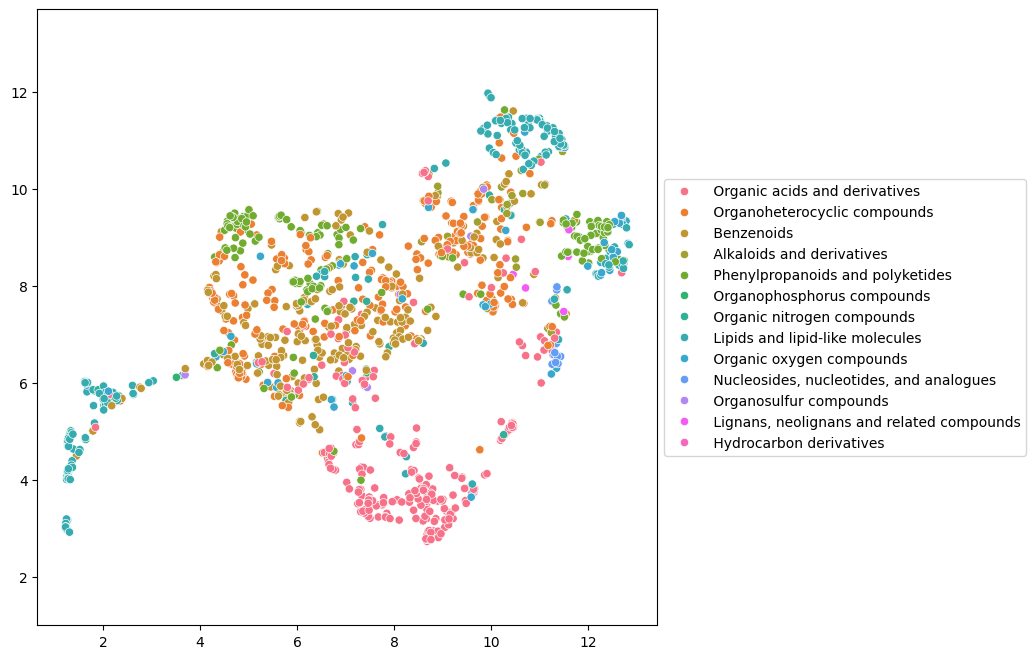

In [81]:
import matplotlib
fig, ax = plt.subplots(1,1, figsize=(8,8))
scatter = sns.scatterplot(
    x=e[:, 0],
    y=e[:, 1],
    hue=test_classes)#, palette=sns.color_palette("colorblind") + ["black", "gray", "white"])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.gca().set_aspect('equal', 'datalim')
ax.set_aspect('equal', 'datalim')
# fig.savefig(f"{home}/images/paper/umap.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/umap.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)

# Get the legend handles and labels
handles = legend.legend_handles

# Get the facecolors from the legend handles (for scatter plot markers)
legend_colors = [handle.get_color() for handle in handles]# if isinstance(handle, matplotlib.patches.PathPatch)]

print(legend_colors)

plt.show()

In [82]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

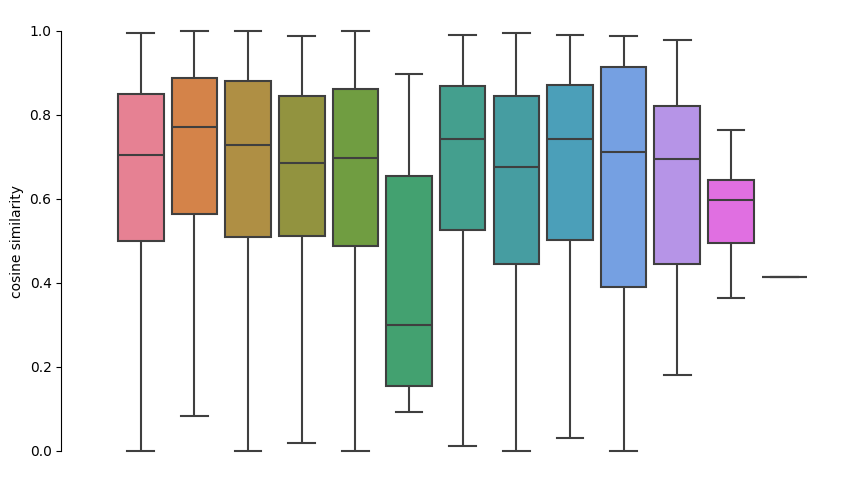

In [94]:
from fiora.visualization.define_colors import adjust_box_widths
fig, ax = plt.subplots(1,1, figsize=(10, 6))

ax = sns.boxplot(ax=ax, data=df_test[df_test["Superclass"] != "nan"], y="spectral_sqrt_cosine", dodge=True, width=0.9, linewidth=1.5, hue="Superclass", legend=False, palette=legend_colors, showfliers=False)
ax.set_ylabel("cosine similarity")
ax.set_xticks([])
sns.despine(offset=10, trim=True)
ax.spines['bottom'].set_visible(False)

adjust_box_widths(fig, 0.85)
fig.savefig(f"{home}/images/paper/cosine_by_class.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"{home}/images/paper/cosine_by_class.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [97]:
df_test.groupby("Superclass").group_id.unique().apply(len)
#df_test.groupby("Superclass").spectral_sqrt_cosine.median()

Superclass
 Alkaloids and derivatives                     26
 Benzenoids                                   240
 Hydrocarbon derivatives                        1
 Lignans, neolignans and related compounds      5
 Lipids and lipid-like molecules              213
 Nucleosides, nucleotides, and analogues       15
 Organic acids and derivatives                257
 Organic nitrogen compounds                    19
 Organic oxygen compounds                      64
 Organoheterocyclic compounds                 271
 Organophosphorus compounds                     3
 Organosulfur compounds                         6
 Phenylpropanoids and polyketides             176
Name: group_id, dtype: int64

#### Tanimoto distance

In [39]:
calc_tanimoto = False # This may tak a long time
if calc_tanimoto:    
    df_cas.loc[:,"tanimoto"] = np.nan
    for i,d in df_cas.iterrows():
        df_cas.at[i, "tanimoto"] = df_train["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
        
    df_cas22.loc[:,"tanimoto"] = np.nan
    for i,d in df_cas22.iterrows():
        df_cas22.at[i, "tanimoto"] = df_train["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
        
    df_test.loc[:,"tanimoto"] = np.nan
    for i,d in df_test.iterrows():
        df_test.at[i, "tanimoto"] = df_train["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()

In [40]:
df_cas["Dataset"] = "CASMI 16"
df_cas22["Dataset"] = "CASMI 22"
df_test["Dataset"] = "Test split"
if calc_tanimoto:
    set_light_theme()
    fig, ax = plt.subplots(1,1, figsize=(12, 6))
    plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08)

    C = pd.concat([df_test, df_cas, df_cas22], ignore_index=True)
    sns.pointplot(ax=ax, data=C, x=pd.cut(C['tanimoto'], bins=[x/10.0 for x in list(range(2,11,1))]), y="spectral_sqrt_cosine", palette=tri_palette, capsize=.0, hue="Dataset", dodge=0.25) #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    plt.ylim([0, 1])
    plt.legend(title="Dataset", loc="lower left")
    plt.ylabel("Cosine similarity")
    plt.xlabel("Tanimoto similarity")

    fig.savefig(f"{home}/images/paper/tanimoto.svg", format="svg", dpi=600, pad_inches=0.1) # bbox_inches='tight',
    fig.savefig(f"{home}/images/paper/tanimoto.png", format="png", dpi=600, pad_inches=0.1)
    plt.show()

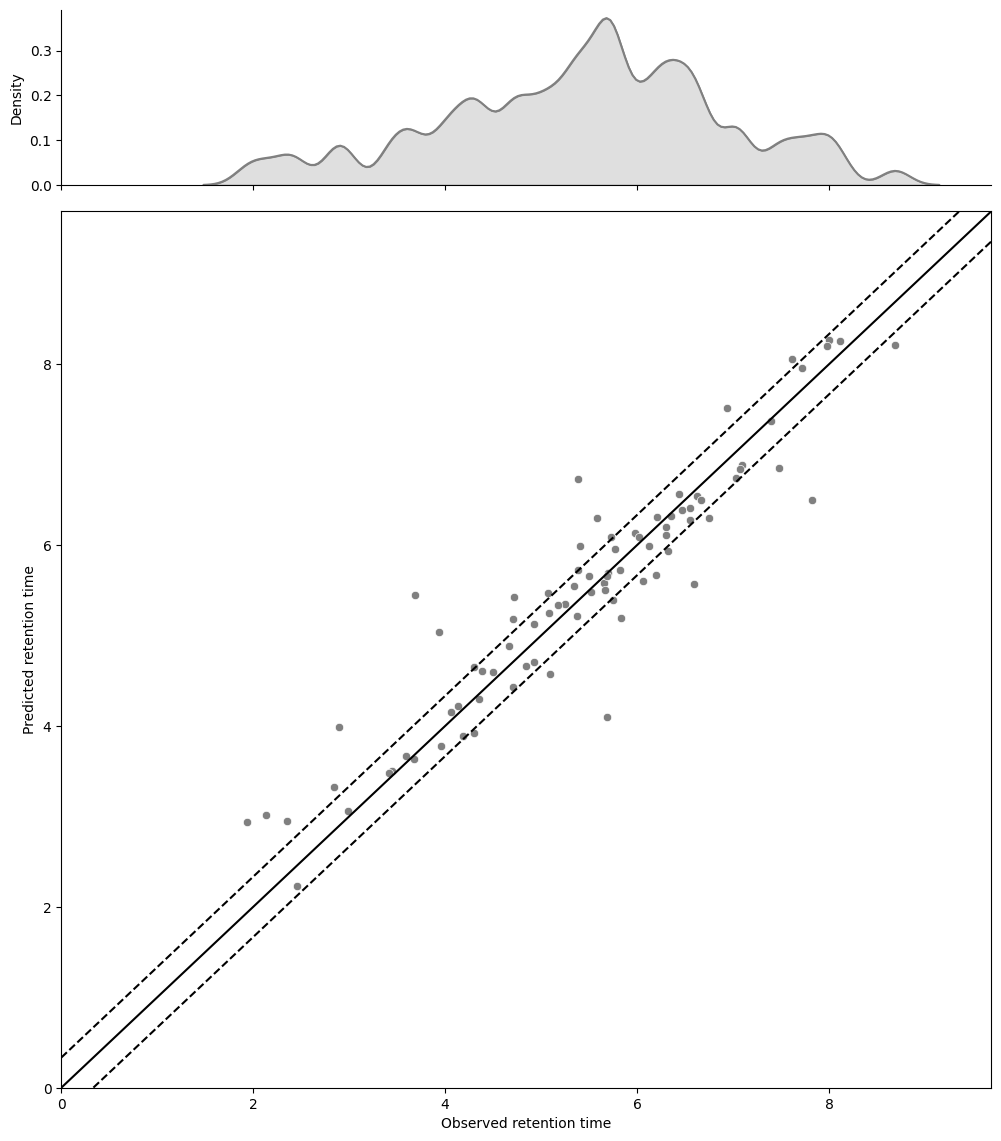

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)
set_light_theme()
set_light_theme()

df_test_unique = df_test.drop_duplicates(subset='SMILES', keep='first')


#sns.histplot(ax=axs[0], data=df_val_unique, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=df_test_unique, x="RETENTIONTIME", bw_adjust=0.25, color="gray", fill=True)#, multiple="stack") #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=df_test_unique, x="RETENTIONTIME", bw_adjust=0.25, color="gray") #, multiple="stack") #hue="Precursor_type", 

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.scatterplot(ax=axs[1], data=df_test_unique, x="RETENTIONTIME", y="RT_pred", color="gray")#, hue="library", palette=tri_palette,  style="library", color="gray")
axs[1].set_ylim([0,df_test_unique["RETENTIONTIME"].max() + 1 ])
axs[1].set_xlim([0,df_test_unique["RETENTIONTIME"].max() + 1])
axs[1].set_ylabel("Predicted retention time")
axs[1].set_xlabel("Observed retention time")
line = [0, 100]
sns.lineplot(ax=axs[1], x=line, y=line, color="black")
sns.lineplot(ax=axs[1], x=line, y=[x + 20/60.0 for x in line], color="black", linestyle='--')
sns.lineplot(ax=axs[1], x=line, y=[x - 20/60.0 for x in line], color="black", linestyle='--')
plt.show()

In [42]:
df_cas22.CCS.isna().all()

True

/tmp/ipykernel_460935/226671181.py:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(ax=axs[0], data=CCS, x="CCS", bw_adjust=0.35, color="black", multiple="stack", hue="Dataset", palette=tri_palette, edgecolor="white") #hue="Precursor_type", palette=["black", "gray"]) #hue="Precursor_type",
/tmp/ipykernel_460935/226671181.py:17: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", hue="Dataset", palette=tri_palette, style="Dataset", markers=[".", "X", "*"], color="gray", s=25, linewidth=.0)#, color="blue", edgecolor="blue")#,
/tmp/ipykernel_460935/226671181.py:17: UserWarning: The markers list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", hue="Dataset", palette=tri_palette, style="Dataset", markers=[".", "X", "*"], color="gray", s=25, linewidth=

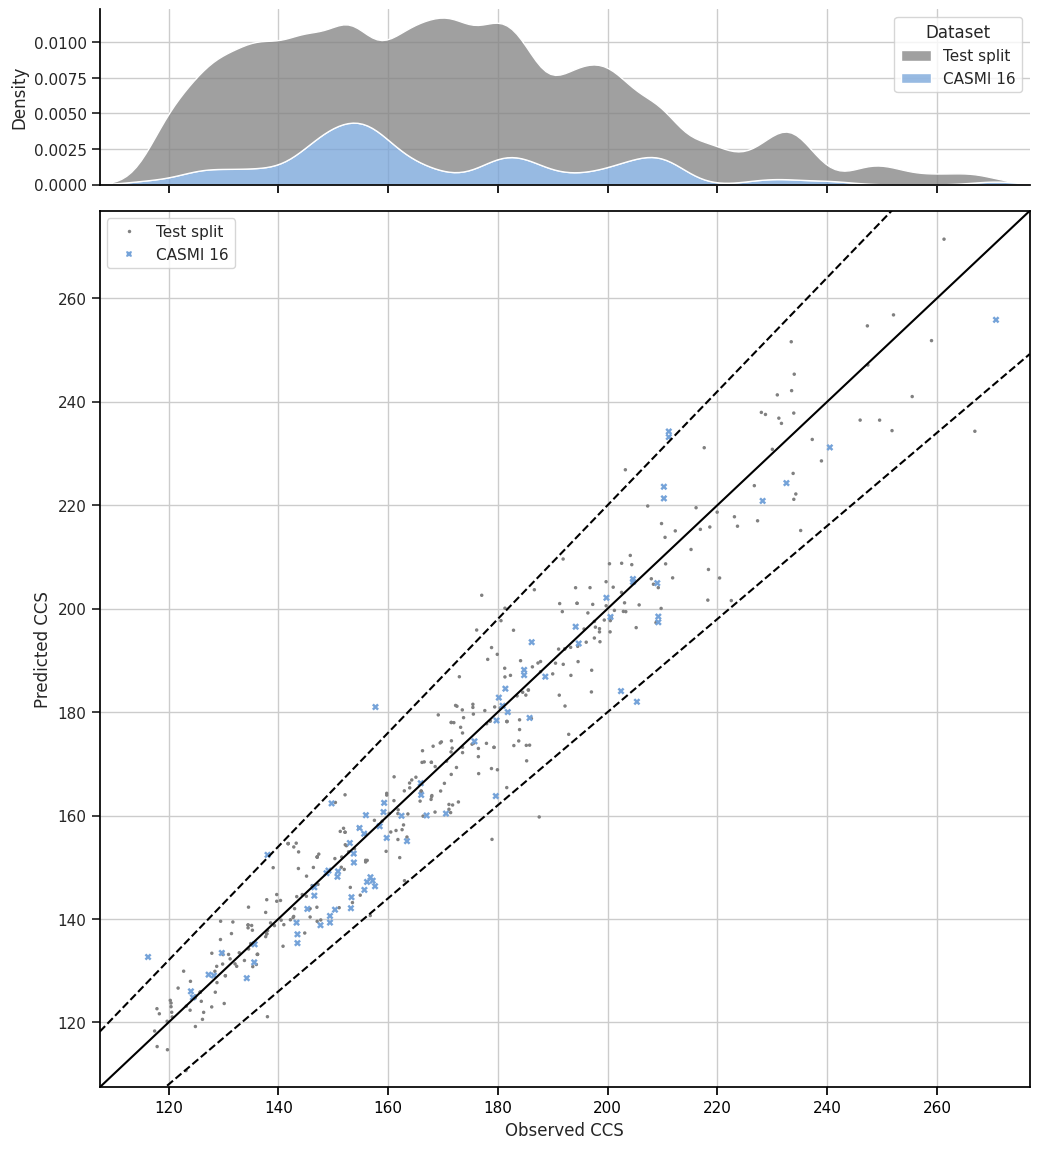

In [43]:
# TODO NEXT UP!!
fig, axs = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)

df_test_unique = df_test.drop_duplicates(subset='SMILES', keep='first')
df_cas22_unique = df_cas22.drop_duplicates(subset='SMILES', keep='first') # Note that with more lenient filters, CCS values might be annotated for CASMI 22

CCS = pd.concat([df_test_unique[["CCS", "CCS_pred", "Dataset"]], df_cas[["CCS", "CCS_pred", "Dataset"]], df_cas22_unique[["CCS", "CCS_pred", "dataset"]] ], ignore_index=True) #


#sns.histplot(ax=axs[0], data=df_val_unique, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=CCS, x="CCS", bw_adjust=0.35, color="black", multiple="stack", hue="Dataset", palette=tri_palette, edgecolor="white") #hue="Precursor_type", palette=["black", "gray"]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", hue="Dataset", palette=tri_palette, style="Dataset", markers=[".", "X", "*"], color="gray", s=25, linewidth=.0)#, color="blue", edgecolor="blue")#, 
axs[1].set_ylim([df_test_unique["CCS"].min() - 10,df_test_unique["CCS"].max() + 10])
axs[1].set_xlim([df_test_unique["CCS"].min() - 10,df_test_unique["CCS"].max() + 10])
axs[1].set_ylabel("Predicted CCS")
axs[1].set_xlabel("Observed CCS")
line=[df_test_unique["CCS"].min() - 10,df_test_unique["CCS"].max() + 10]
sns.lineplot(ax=axs[1], x=line, y=line, color="black")
sns.lineplot(ax=axs[1], x=line, y=[1.1*x for x in line], color="black", linestyle='--')
sns.lineplot(ax=axs[1], x=line, y=[0.9*x for x in line], color="black", linestyle='--')
plt.show()

In [44]:

print("TEST SPLIT:\n")
print("Pearson Corr Coef:")
print("GNN", np.corrcoef(df_test_unique.dropna(subset=["CCS"])["CCS"], df_test_unique.dropna(subset=["CCS"])["CCS_pred"].dropna(), dtype=float)[0,1])
print("LR ", np.corrcoef(df_test_unique.dropna(subset=["CCS"])["CCS"], df_test_unique.dropna(subset=["CCS"])["PrecursorMZ"].dropna(), dtype=float)[0,1])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_train.dropna(subset=["CCS"])["PRECURSORMZ"], df_train.dropna(subset=["CCS"])["CCS"])
print("R2")
print("GNN", r2_score(df_test_unique.dropna(subset=["CCS"])["CCS"], df_test_unique.dropna(subset=["CCS"])["CCS_pred"].dropna()))
print("LR ", r2_score(df_test_unique.dropna(subset=["CCS"])["CCS"], intercept + slope *df_test_unique.dropna(subset=["CCS"])["PrecursorMZ"].dropna()))

print("---------------\n\nCASMI-16:\n")
print("Pearson Corr Coef:")
print("GNN", np.corrcoef(df_cas.dropna(subset=["CCS"])["CCS"], df_cas.dropna(subset=["CCS"])["CCS_pred"].dropna(), dtype=float)[0,1])
print("LR ", np.corrcoef(df_cas.dropna(subset=["CCS"])["CCS"], df_cas.dropna(subset=["CCS"])["PRECURSOR_MZ"].dropna(), dtype=float)[0,1])
print("R2")
print("GNN", r2_score(df_cas.dropna(subset=["CCS"])["CCS"], df_cas.dropna(subset=["CCS"])["CCS_pred"].dropna()))
print("LR ", r2_score(df_cas.dropna(subset=["CCS"])["CCS"], intercept + slope *df_cas.dropna(subset=["CCS"])["PRECURSOR_MZ"].dropna()))

TEST SPLIT:

Pearson Corr Coef:
GNN 0.9739341719837402
LR  0.9540329723367412
R2
GNN 0.9480016013468511
LR  0.9087642739687899
---------------

CASMI-16:

Pearson Corr Coef:
GNN 0.9598623386878294
LR  0.7941692301553979
R2
GNN 0.9154955105529023
LR  0.6112236492203522


In [45]:
# Load coverage into dataframe
df_test["coverage"] = df_test["Metabolite"].apply(lambda x: x.match_stats["coverage"]) 
df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"]) 
df_cas22["coverage"] = df_cas22["Metabolite"].apply(lambda x: x.match_stats["coverage"]) 

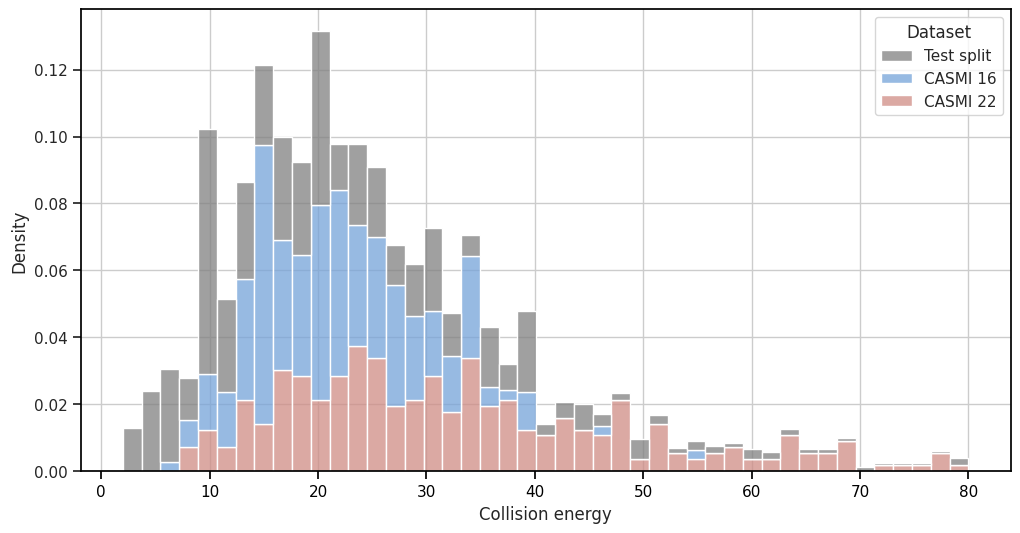

In [46]:
CAT = pd.concat([df_test, df_cas, df_cas22])
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
set_light_theme()
sns.histplot(ax=ax, data=CAT, x="CE", hue="Dataset", multiple="stack", palette=tri_palette, stat="density", common_norm=False, kde=False)
plt.xlabel("Collision energy")
plt.show()

In [47]:
CAT.head()

,Name,Synon,Notes,Precursor_type,Spectrum_type,PrecursorMZ,Instrument_type,Instrument,Sample_inlet,Ionization,...,merged_sqrt_bias,merged_sqrt_cosine_wo_precursor,merged_refl_cosine,merged_steins,library,RT_min,precursor_mz,ChallengeRT,ChallengeNum,is_priority
92,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df_test.columns

Index(['Name', 'Synon', 'Notes', 'Precursor_type', 'Spectrum_type',
       'PrecursorMZ', 'Instrument_type', 'Instrument', 'Sample_inlet',
       'Ionization',
       ...
       'cfm_peaks', 'cfm_cosine', 'cfm_sqrt_cosine', 'cfm_refl_cosine',
       'cfm_steins', 'Superclass', 'Subclass', 'Class', 'Dataset', 'coverage'],
      dtype='object', length=104)

Challenge-002
0.6865432793233913
0.25855397794175855
0.6865432793233913
0.25855397794175855


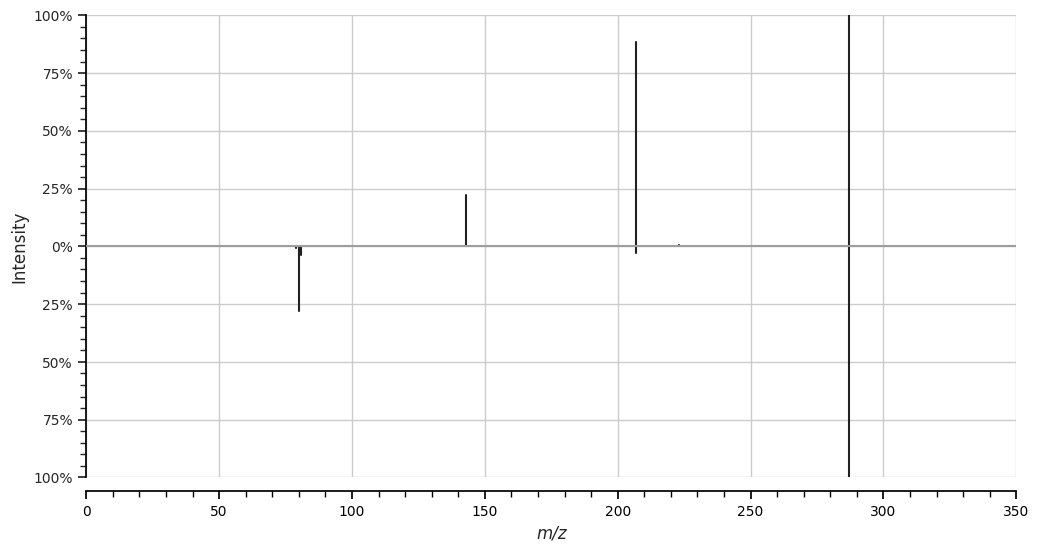

In [49]:
i = 1

print(df_cas.iloc[i]["ChallengeName"])
print(spectral_cosine(df_cas.iloc[i].peaks, df_cas.iloc[i].sim_peaks, transform=np.sqrt))
print(spectral_cosine(df_cas.iloc[i].peaks, df_cas.iloc[i].sim_peaks, transform=np.sqrt, remove_mz=df_cas.iloc[i]["PRECURSOR_MZ"]))
print(df_cas.iloc[i].spectral_sqrt_cosine)
print(df_cas.iloc[i].merged_sqrt_cosine_wo_precursor)
sv.plot_spectrum(df_cas.iloc[i], {"peaks": df_cas.iloc[i].sim_peaks})
plt.show()

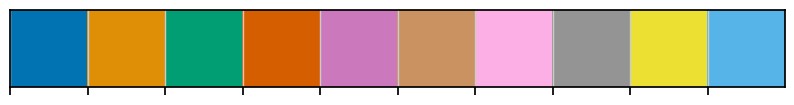

In [50]:
sns.palplot(sns.color_palette("colorblind"))
plt.show()

/tmp/ipykernel_460935/573305049.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels)


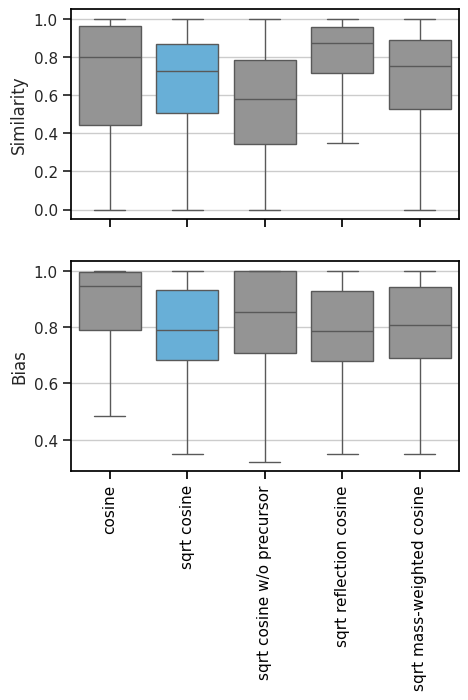

In [51]:
set_light_theme()
scores = ["spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "steins_cosine"]
biases = [s.replace("cosine", "bias") for s in scores]
#labels = ["cosine", r"cosine $\sqrt{int}$ ", r"$\sqrt{i}$ cosine w/o precursor", r"$\sqrt{i}$ reflection cosine", r"$\sqrt{i}$ mass-weighted cosine"]

labels = ["cosine", "sqrt cosine", "sqrt cosine w/o precursor", "sqrt reflection cosine", "sqrt mass-weighted cosine"]
S = df_test.melt(id_vars="Name", var_name="Score", value_vars=scores)
B = df_test.melt(id_vars="Name", var_name="Score", value_vars=biases)


fig, axs = plt.subplots(2, 1, figsize=(5, 6), sharex=False)

highlight_2=[sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[9], sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[7]]
sns.boxplot(ax=axs[0], data=S, y="value", x="Score", order=scores, hue="Score", palette=highlight_2, showfliers=False)
sns.boxplot(ax=axs[1], data=B, y="value", x="Score", order=biases, hue="Score", palette=highlight_2, showfliers=False)
axs[0].set_xticklabels("")
axs[0].set_xlabel("")
axs[0].set_ylabel("Similarity")
axs[1].set_xlabel("")
axs[1].set_xticklabels(labels)
axs[1].set_ylabel("Bias")
#axs[1].set_ylim([0, 1])
#axs[1].axhline(y=B.groupby('Score')['value'].median().min(), xmin=0, xmax=10, color="red", linestyle="--")

plt.xticks(rotation=90)
plt.show()


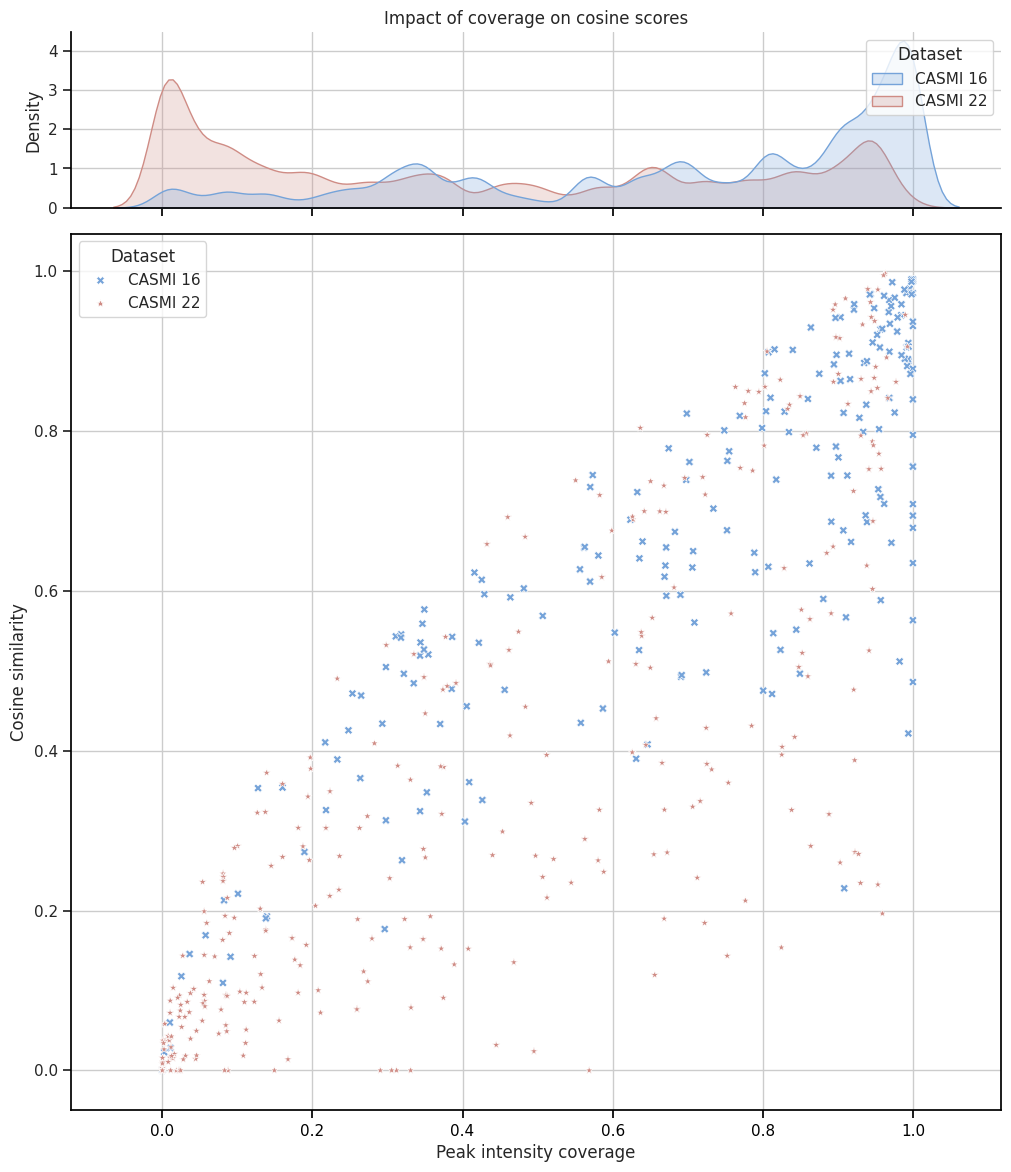

In [52]:
fig, axs = plt.subplots(2, 1, figsize=(12, 14), sharex=True, gridspec_kw={'height_ratios': [1, 5]})
plt.subplots_adjust(hspace=0.05)#right=0.975, left=0.11)
#sns.histplot(ax=axs[0], data=df_cas22, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=CAT[CAT["Dataset"] != "Test split"], x="coverage", bw_adjust=0.2, color="black", fill=True, multiple="layer", hue="Dataset", common_norm=False, palette=tri_palette[1:]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[0].set_title("Impact of coverage on cosine scores")
sns.scatterplot(ax=axs[1], data=CAT[CAT["Dataset"] != "Test split"], x="coverage", y="spectral_sqrt_cosine", hue="Dataset", style="Dataset", markers=[".", "X", "*"][1:], marker=".", palette=tri_palette[1:]) #, hue_norm=(0, 1), palette=bluepink_grad)
axs[1].set_ylabel("Cosine similarity")
axs[1].set_xlabel("Peak intensity coverage")
plt.show()

In [53]:
ids = [17, 58, 68, 75, 102, 107, 128, 145, 163, 205]
example_input = df_cas.loc[ids].copy()[["SMILES", "avg_CE", "Precursor_type", "Instrument_type"]]
example_input["CE"] = example_input["avg_CE"].astype(int)
example_input["Name"] = [f"Example_{i}" for i in range(example_input.shape[0])]
# example_input[["Name", "SMILES", "Precursor_type", "CE", "Instrument_type"]].to_csv("../examples/example_input.csv", index=False)
example_input[["Name", "SMILES", "Precursor_type", "CE", "Instrument_type"]]

,Name,SMILES,Precursor_type,CE,Instrument_type
17,Example_0,CC1=CC(=O)OC2=CC(OS(O)(=O)=O)=CC=C12,[M-H]-,17,HCD
58,Example_1,CC12CCC3C(CCC4=CC(OS(O)(=O)=O)=CC=C34)C1CCC2=O,[M-H]-,24,HCD
68,Example_2,ClC1=CC=C(NC(=O)NC2=CC=C(Cl)C(Cl)=C2)C=C1,[M-H]-,21,HCD
75,Example_3,Oc1c(Cl)cc(Cl)cc1C(=O)Nc1ccc(Cl)c(Cl)c1,[M-H]-,24,HCD
102,Example_4,NC(=O)\C=C\C1=CC=CC=C1,[M+H]+,10,HCD
107,Example_5,ClC1=CC2=C(C=C1)N(C1CCN(CCCN3C(=O)NC4=C3C=CC=C...,[M+H]+,29,HCD
128,Example_6,C1CCC(CC1)NC1=NC2=CC=CC=C2S1,[M+H]+,16,HCD
145,Example_7,CCCCC1=C(C)N=C(NCC)N=C1OS(=O)(=O)N(C)C,[M+H]+,22,HCD
163,Example_8,CC(C)(C)C1=CC=C(C=C1)C(=O)CCCN1CCC(CC1)OC(C1=C...,[M+H]+,32,HCD
205,Example_9,FC1=CC(OC2=CC=C(C=C2Cl)C(F)(F)F)=CC=C1NC(=O)NC...,[M+H]+,34,HCD


(4, 105)
100


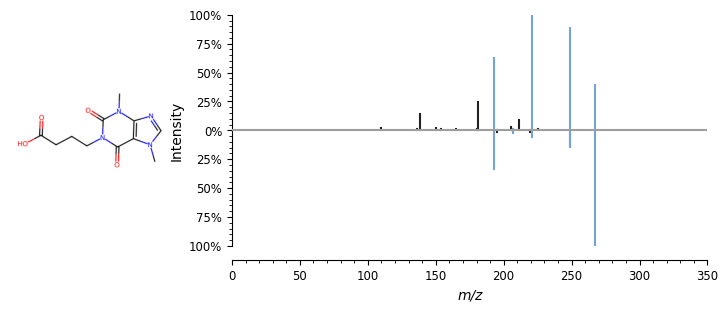

102


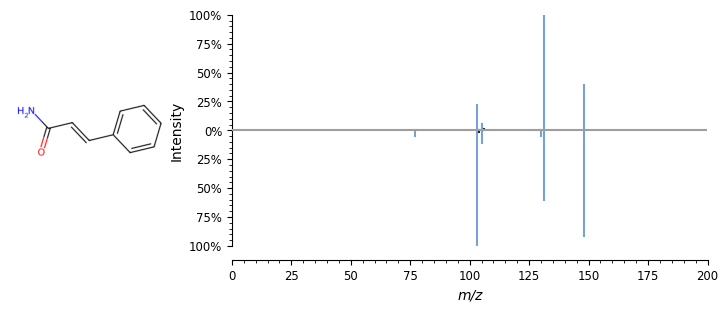

107


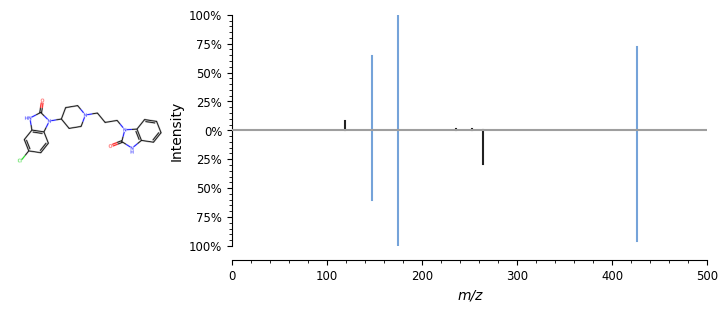

163


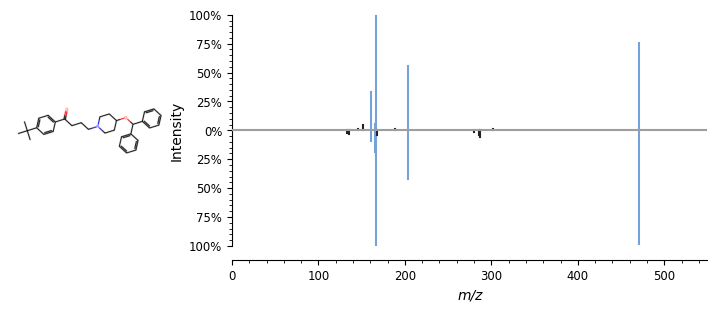

In [54]:
reset_matplotlib()

df_print = df_cas[(df_cas["merged_sqrt_cosine"] > 0.70) & (df_cas["merged_sqrt_bias"] < 0.6)]
#df_print = df_test[(df_test["spectral_sqrt_cosine"] > 0.85) & (df_test["spectral_sqrt_bias"] < 0.6) & (df_test["lib"] == "MSDIAL")]

print(df_print.shape)
for i, data in df_print.iterrows():
    fig, axs = plt.subplots(1, 2, figsize=(9,3), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
    img = data["Metabolite"].draw(ax= axs[0])
    print(i)
    sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, highlight_matches=True, ppm_tolerance=200, ax=axs[1])
    plt.show()

(29, 104)
76716


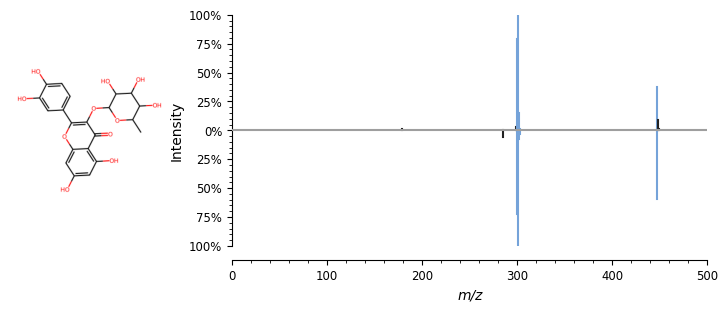

76728


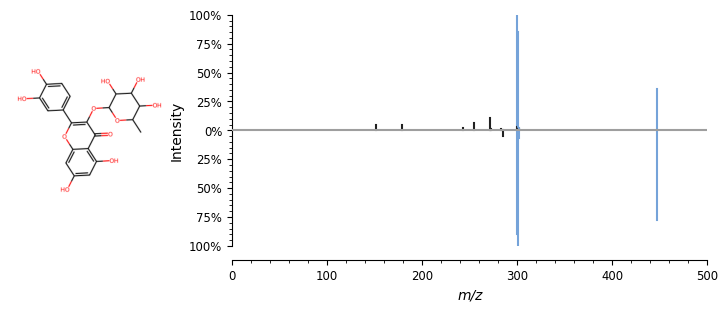

78024


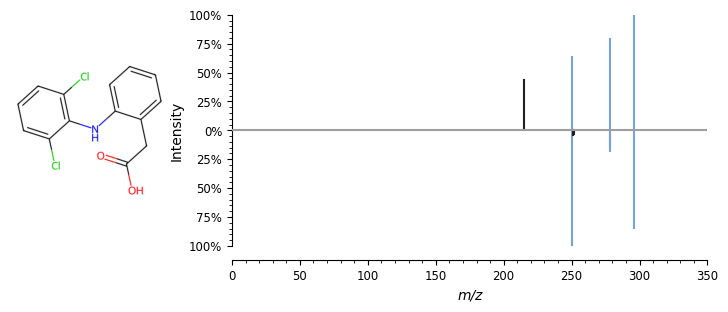

78027


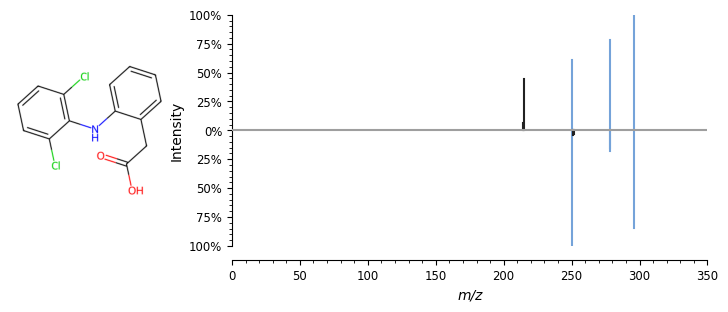

82297


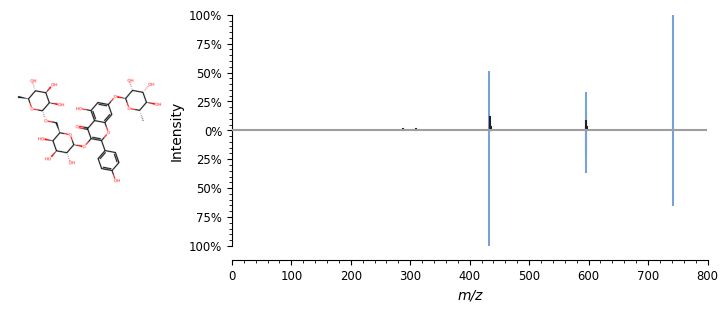

83474


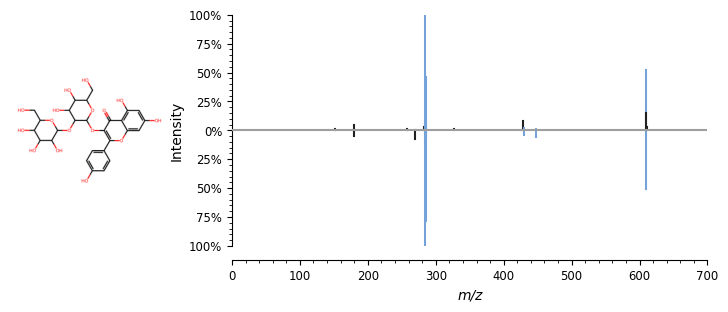

83920


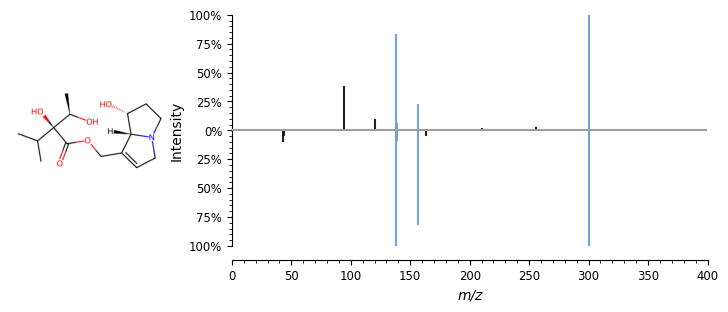

85069


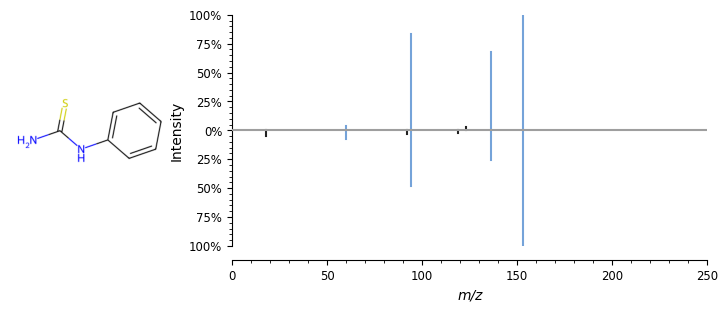

85070


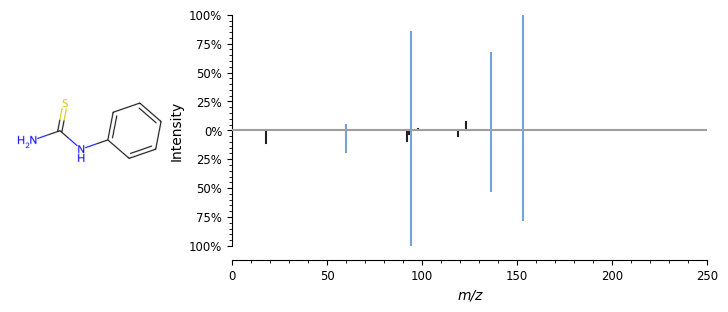

85073


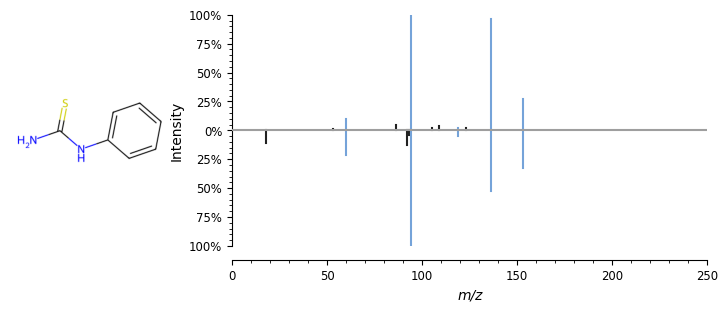

85767


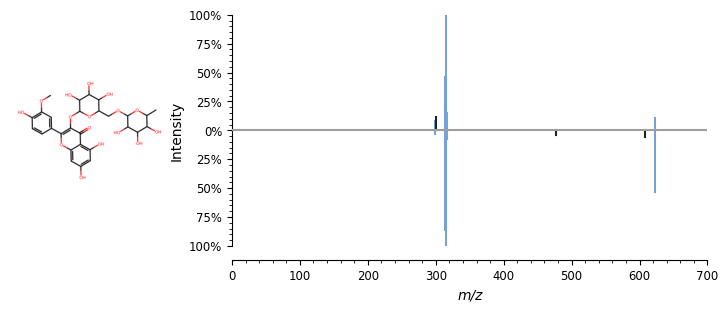

89191


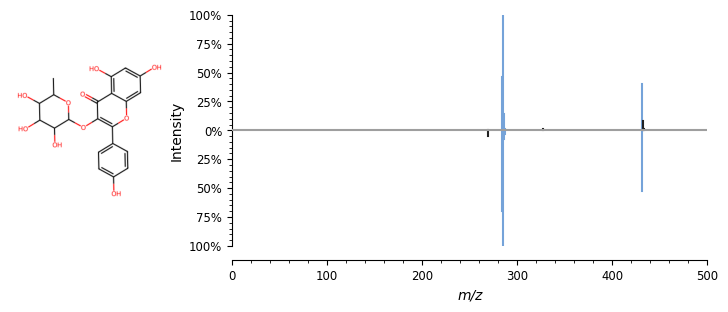

89198


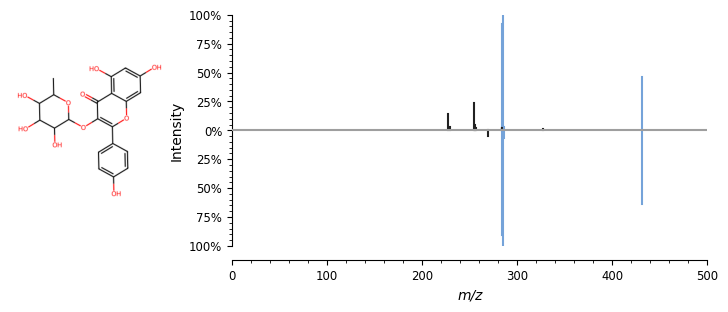

97091


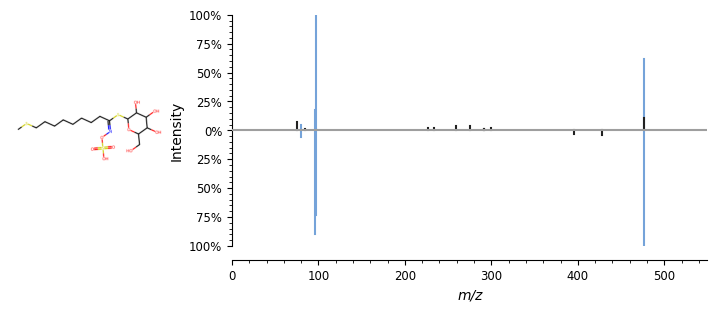

97214


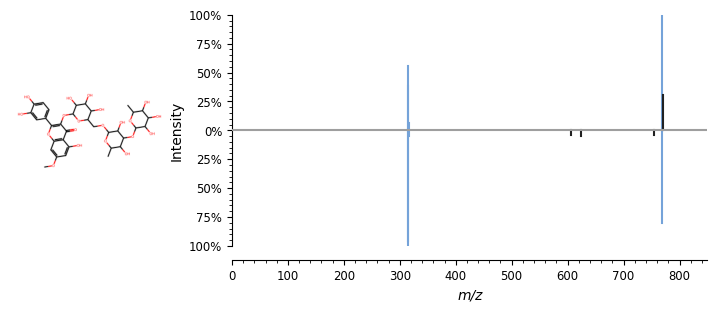

97591


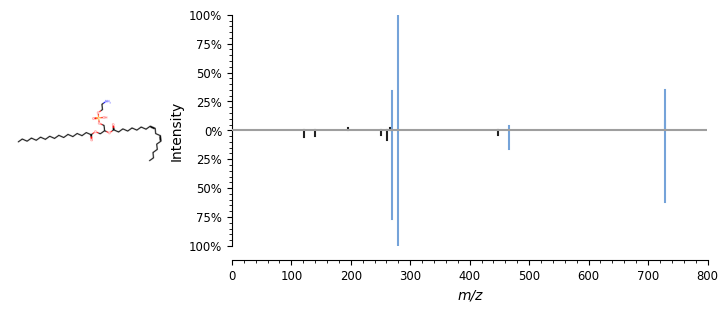

97592


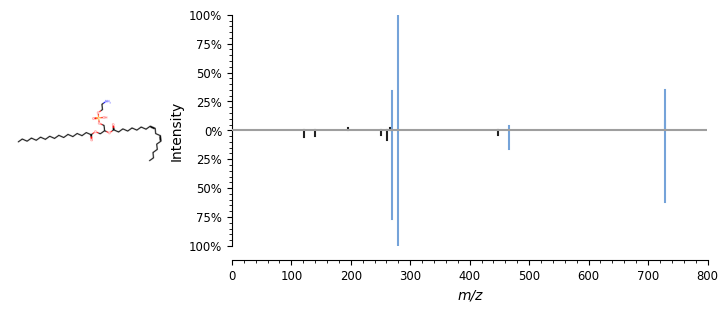

97675


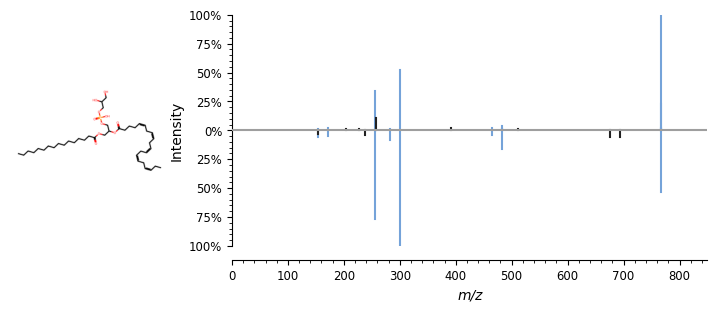

97676


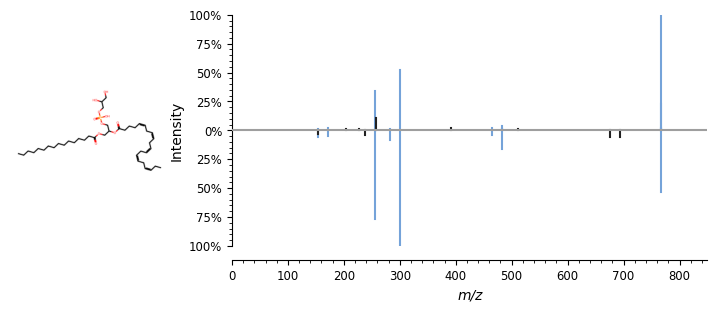

97677


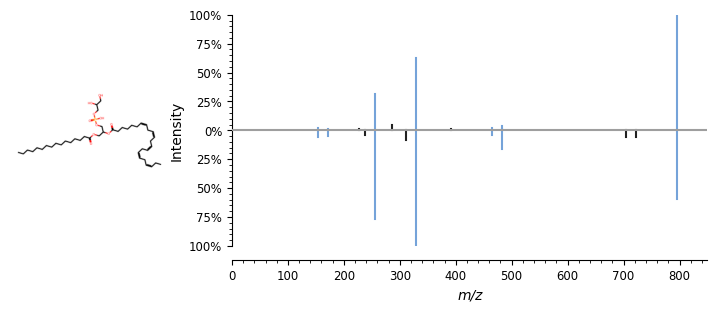

97678


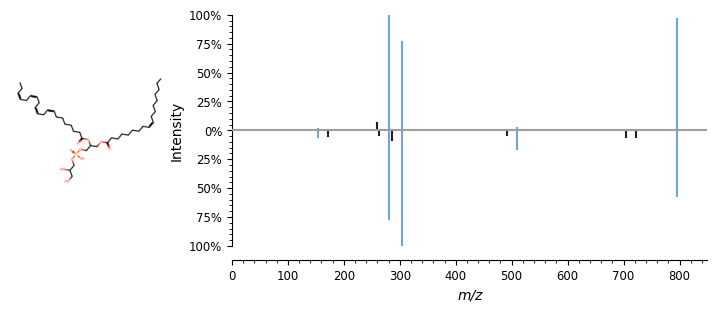

97679


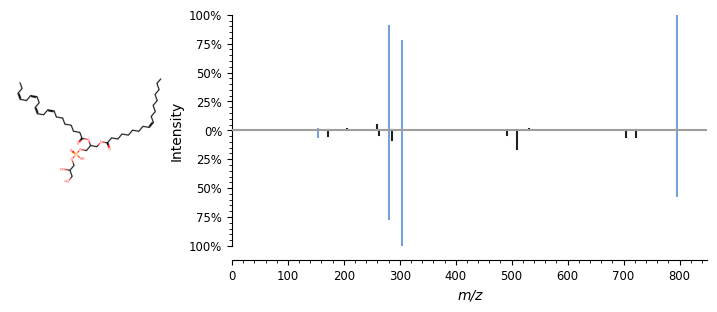

97680


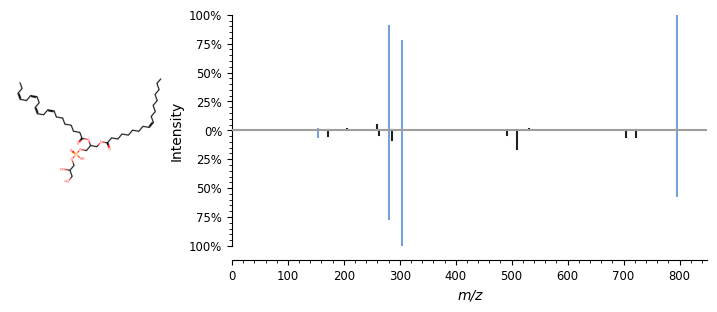

97681


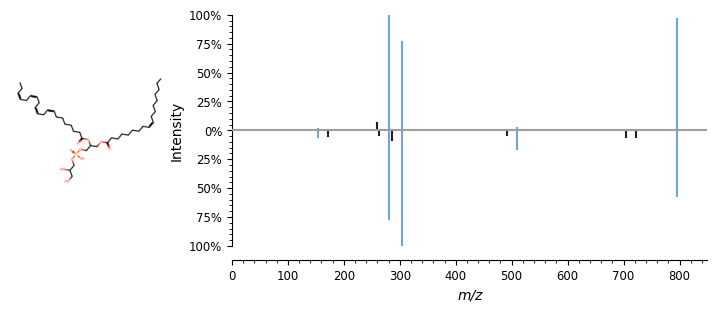

97682


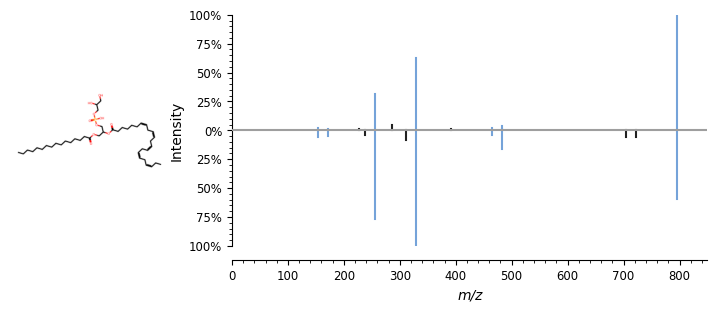

97693


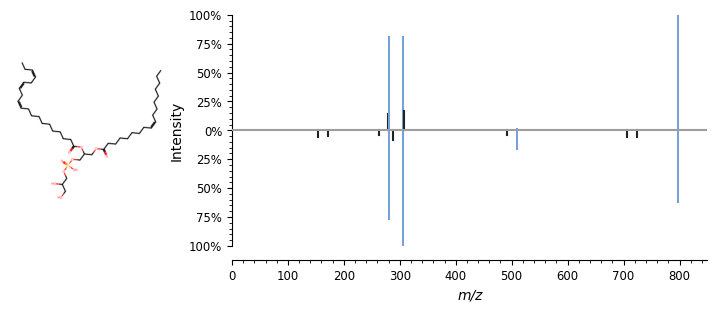

97694


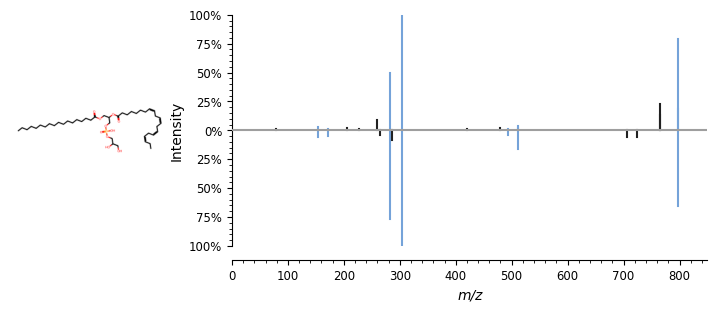

97695


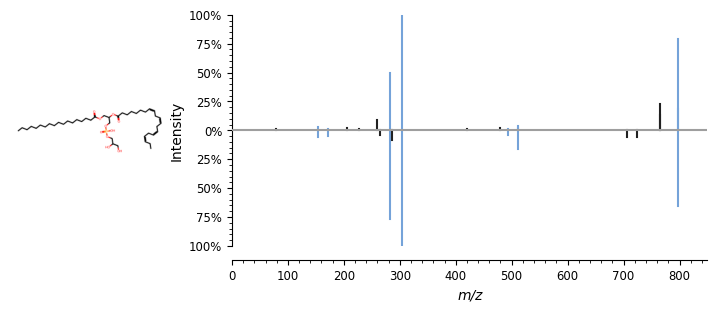

97696


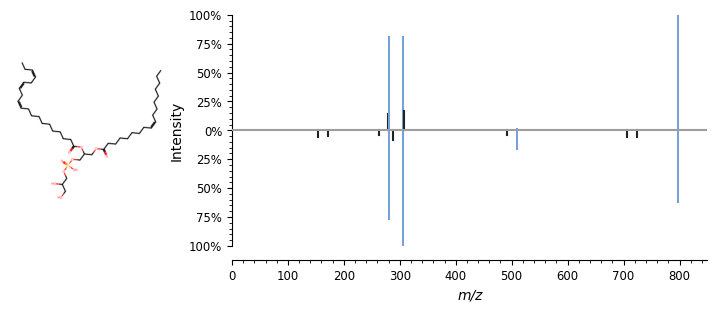

In [55]:
df_print = df_test[(df_test["spectral_sqrt_cosine"] > 0.85) & (df_test["spectral_sqrt_bias"] < 0.6) & (df_test["lib"] == "MSDIAL")]

print(df_print.shape)
for i, data in df_print.iterrows():
    fig, axs = plt.subplots(1, 2, figsize=(9,3), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
    img = data["Metabolite"].draw(ax= axs[0])
    print(i)
    sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, highlight_matches=True, ppm_tolerance=200, ax=axs[1])
    plt.show()